# InputProcessing

In [1]:
import pandas

weather_data = pandas.read_csv("Weather data.csv", sep=",")
# drop duplicates
weather_data = weather_data.drop_duplicates(subset="dt")

# remove last 2 hours since we have no associated energy data for it
weather_data = weather_data[:-2]

# interpret date column from string to UTC
weather_data["Date"] = pandas.to_datetime(weather_data["dt_iso"]).dt.tz_localize("UTC")

# reset index
weather_data = weather_data.reset_index()

## Outlier Detection

The weather data is hourly and our energy_data is quarter-hourly. Therefore, we will merge each 4 rows of the energy_data to map them to the weather data. But before we do that we detect outliers in the energy data. Otherwise, the sum of 4 energy values could average out the outliers.

In [2]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

def find_outliers(data):
    # The contamination factor specifies the relative amounf of expected outliers.
    # We tuned this parameter by investigating the scatter plot below.
    # We can see the positive effect of eliminating outliers on the model by looking at 
    # the correlation between the temperature and the energey use (see table below).
    iso = EllipticEnvelope(contamination=0.01, support_fraction=1.0)
    outliers = iso.fit_predict(data)
    return outliers

In [3]:
energy_data = pandas.read_csv("Energy_use_houshold_summary.csv", sep=",")

# convert to utc
energy_data["Date"] = pandas.to_datetime(energy_data["Date"]).dt.tz_localize("Europe/Vienna").dt.tz_convert("UTC")

# remove first three entries since we have no associated weather data for it
energy_data = energy_data[3:]

# reset index
energy_data = energy_data.reset_index()

energy_data["timestamp"] = energy_data["Date"].apply(lambda x:x.timestamp())

# new column for numerical day in the year
energy_data["year_day"] = energy_data["Date"].apply(lambda d: d.timetuple().tm_yday)

# new column for seconds since midnight
energy_data["day_time"] = energy_data["timestamp"] % (24 * 3600)

# Detect outliers => outliers are marked with -1 and non-outliers with 1
energy_data["outliers"] = find_outliers(energy_data[["year_day", "day_time", "kWh"]])
# Change the marks outliers with 1 and non-outliers with 0 to be able to sum up
energy_data["outliers"] = energy_data["outliers"].map({-1: 1, 1: 0})

## Plot outliers (time -> kWh)

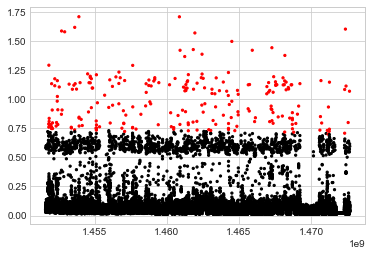

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

colors = {1: 'red', 0: 'black'}

#plt.rcParams['figure.figsize'] = [60, 30]
plt.scatter(energy_data["timestamp"], energy_data["kWh"], 5, c=energy_data["outliers"].map(colors))

In [5]:
# sum energy_data over quarter hours
energy_data = energy_data.groupby(energy_data.index // 4).agg({'Date': 'first', 'kWh': 'sum', 'timestamp': 'first', 'year_day': 'first', 'day_time': 'first', 'outliers': 'sum'})

In [6]:
# merge the two datasets
data = pandas.merge(weather_data, energy_data, on='Date', how='inner')


# remove rows with at least one outlier
rowsWithOutliers = data.shape[0]
data = data[data.outliers.eq(0)]
rowsWithoutOutliers = data.shape[0]

print("Removed outliers:", (rowsWithOutliers - rowsWithoutOutliers) / rowsWithOutliers)

data["week_day"] = data["Date"].dt.dayofweek
data["precipitation"] = data["rain_1h"].fillna(0) + data["snow_1h"].fillna(0)

Removed outliers: 0.036385377519644685


In [7]:
data["mWh"] = (data["kWh"] * 1000000).astype(int)

In [8]:
def encode_cyclical(data, column, range):
    data[column + "_norm"] = 2 * pi * data[column] / range
    data[column +"_sin"] = np.sin(data[column + "_norm"])
    data[column +"_cos"] = np.cos(data[column + "_norm"])

In [9]:
from math import pi

encode_cyclical(data, "week_day", 7)

# new column for numerical day in the year
data["year_day"] = data["Date"].apply(lambda d: d.timetuple().tm_yday)

# new column for day hour
data["day_time"] = (data["dt"] // 3600) % 24

# encode day in the year and day hour
encode_cyclical(data, "year_day", 365)
encode_cyclical(data, "day_time", 3600 * 24)

In [10]:
data

,index,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,...,mWh,week_day_norm,week_day_sin,week_day_cos,year_day_norm,year_day_sin,year_day_cos,day_time_norm,day_time_sin,day_time_cos
0,0,1451606400,2016-01-01 00:00:00,3600,Graz,47.070714,15.439504,-5.17,-8.73,-6.9,...,203186,3.590392,-0.433884,-0.900969,0.017214,0.017213,0.999852,0.000000,0.000000,1.000000
1,1,1451610000,2016-01-01 01:00:00,3600,Graz,47.070714,15.439504,-4.91,-8.46,-6.3,...,266899,3.590392,-0.433884,-0.900969,0.017214,0.017213,0.999852,0.000073,0.000073,1.000000
2,2,1451613600,2016-01-01 02:00:00,3600,Graz,47.070714,15.439504,-4.86,-8.41,-6.5,...,802072,3.590392,-0.433884,-0.900969,0.017214,0.017213,0.999852,0.000145,0.000145,1.000000
3,3,1451617200,2016-01-01 03:00:00,3600,Graz,47.070714,15.439504,-4.46,-8.00,-5.7,...,174896,3.590392,-0.433884,-0.900969,0.017214,0.017213,0.999852,0.000218,0.000218,1.000000
4,4,1451620800,2016-01-01 04:00:00,3600,Graz,47.070714,15.439504,-4.15,-7.68,-5.1,...,151216,3.590392,-0.433884,-0.900969,0.017214,0.017213,0.999852,0.000291,0.000291,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849,5920,1472662800,2016-08-31 17:00:00,7200,Graz,47.070714,15.439504,20.71,19.41,12.2,...,266856,1.795196,0.974928,-0.222521,4.200266,-0.871706,-0.490029,0.001236,0.001236,0.999999
5850,5921,1472666400,2016-08-31 18:00:00,7200,Graz,47.070714,15.439504,18.24,17.89,11.6,...,246414,1.795196,0.974928,-0.222521,4.200266,-0.871706,-0.490029,0.001309,0.001309,0.999999
5851,5922,1472670000,2016-08-31 19:00:00,7200,Graz,47.070714,15.439504,16.85,16.38,11.6,...,343435,1.795196,0.974928,-0.222521,4.200266,-0.871706,-0.490029,0.001382,0.001382,0.999999
5852,5923,1472673600,2016-08-31 20:00:00,7200,Graz,47.070714,15.439504,16.03,15.49,11.5,...,828578,1.795196,0.974928,-0.222521,4.200266,-0.871706,-0.490029,0.001454,0.001454,0.999999


In [11]:
# define important columns and forget the rest
data = data[[
        "temp", "pressure", "humidity", "wind_speed", "wind_deg",
        "rain_1h", "snow_1h", "clouds_all", "mWh", "precipitation",
        "week_day_sin", "week_day_cos", "year_day_sin", "year_day_cos",
        "day_time_sin", "day_time_cos"]]

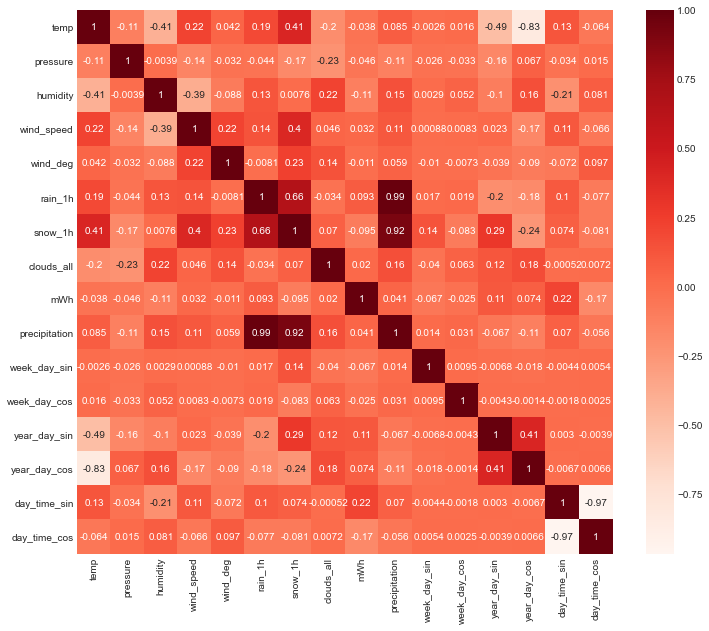

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [13]:
# REMOVE IF NOT USED!

# Encode all possible combinations of the seven features ["temp", "pressure", "humidity", "wind_speed", "rain_1h", "snow_1h", "clouds_all"]
# via a numeric between 0 and 127 by using its binary representation to decide if a feature is used or not.
# We can then introduce a numerical hypeparmater in the range [0,127] that specifies which features we use

def getFeatureSet(i):
    set = []
    for column in ["temp", "pressure", "humidity", "wind_speed", "rain_1h", "snow_1h", "clouds_all"]:
        if i % 2 == 1:
            set.append(column)
        i = i // 2
    return set

# Prepare test and training sets

In [14]:
from sklearn.model_selection import train_test_split

features = ["temp", "pressure", "humidity", "precipitation", "clouds_all", 
            "week_day_sin", "week_day_cos", "year_day_sin", 
            "year_day_cos", "day_time_sin", "day_time_cos"]

target = "mWh"

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y)

display(y_train)
display(y_test)

834     832038
2618    151474
454     895766
3221    526209
1683    148575
         ...  
5378    105902
565     147966
1075    171713
3934    148216
2733    788322
Name: mWh, Length: 4230, dtype: int32

4945    109388
5791    202544
5728     88304
495     958577
3688    172739
         ...  
2034    780099
131     206542
2349    148172
4922    118736
2804    715335
Name: mWh, Length: 1411, dtype: int32

# Apply methods

In [15]:
from sklearn import metrics

def fit_and_test(model):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    # plot the prediction vs the real values
    plt.scatter(y_test, y_predict)
    
    # compute R^2 Score
    print("R^2 =", metrics.r2_score(y_test, y_predict))
    
    # compute RMSE
    print("RMSE =", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

## Linear Regression

R^2 = 0.08754851284323117
RMSE = 329169.61519995733


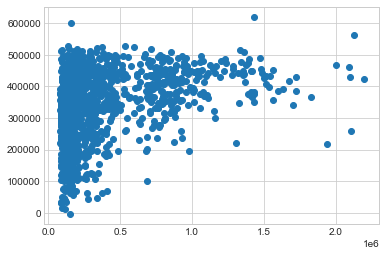

In [16]:
from sklearn import linear_model
fit_and_test(linear_model.LinearRegression())

## Support Vector Regression

In [17]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = [{
'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
'C': [1,2,3,300,500],
'max_iter': [1000,100000]}]


#fit_and_test(GridSearchCV(svm.SVR(), parameters, scoring='r2'))
#fit_and_test(svm.SVR())

## Decision Tree

C:\Users\Florian\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


R^2 = 0.9991469324895211
RMSE = 10064.83243898303


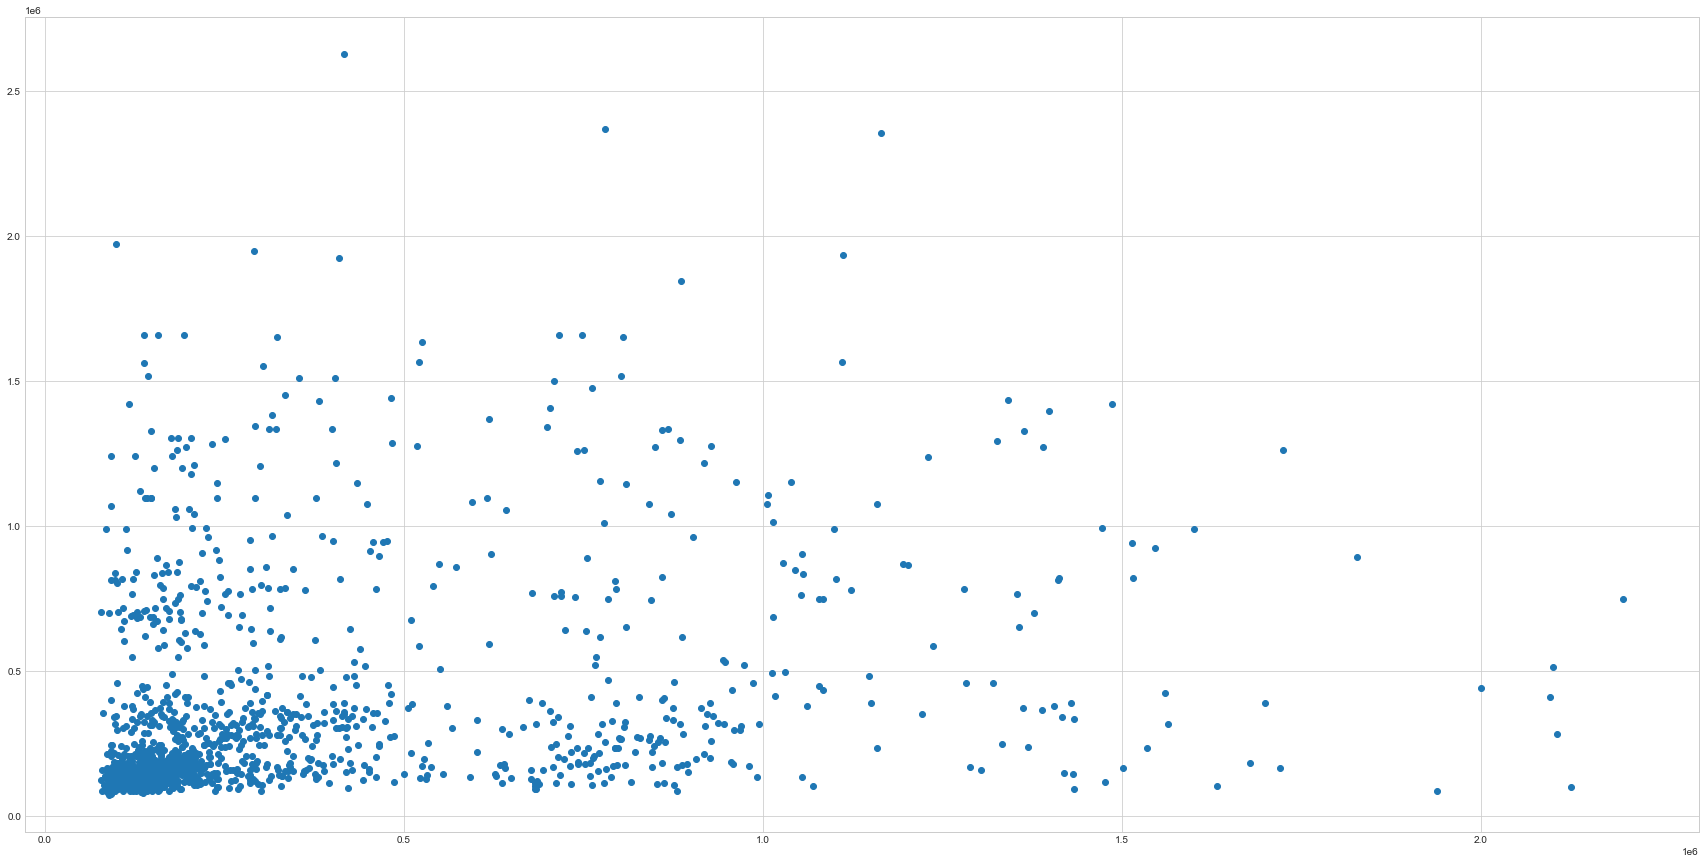

In [20]:
from sklearn import tree

parameters = [{
'criterion': ['gini', 'entropy'], 
'splitter': ['best', 'random']}]

plt.rcParams['figure.figsize'] = [30, 15]
fit_and_test(GridSearchCV(tree.DecisionTreeClassifier(), parameters, scoring='r2'))

## Neural Network

R^2 = 0.02389944289058399
RMSE = 340456.8906181602


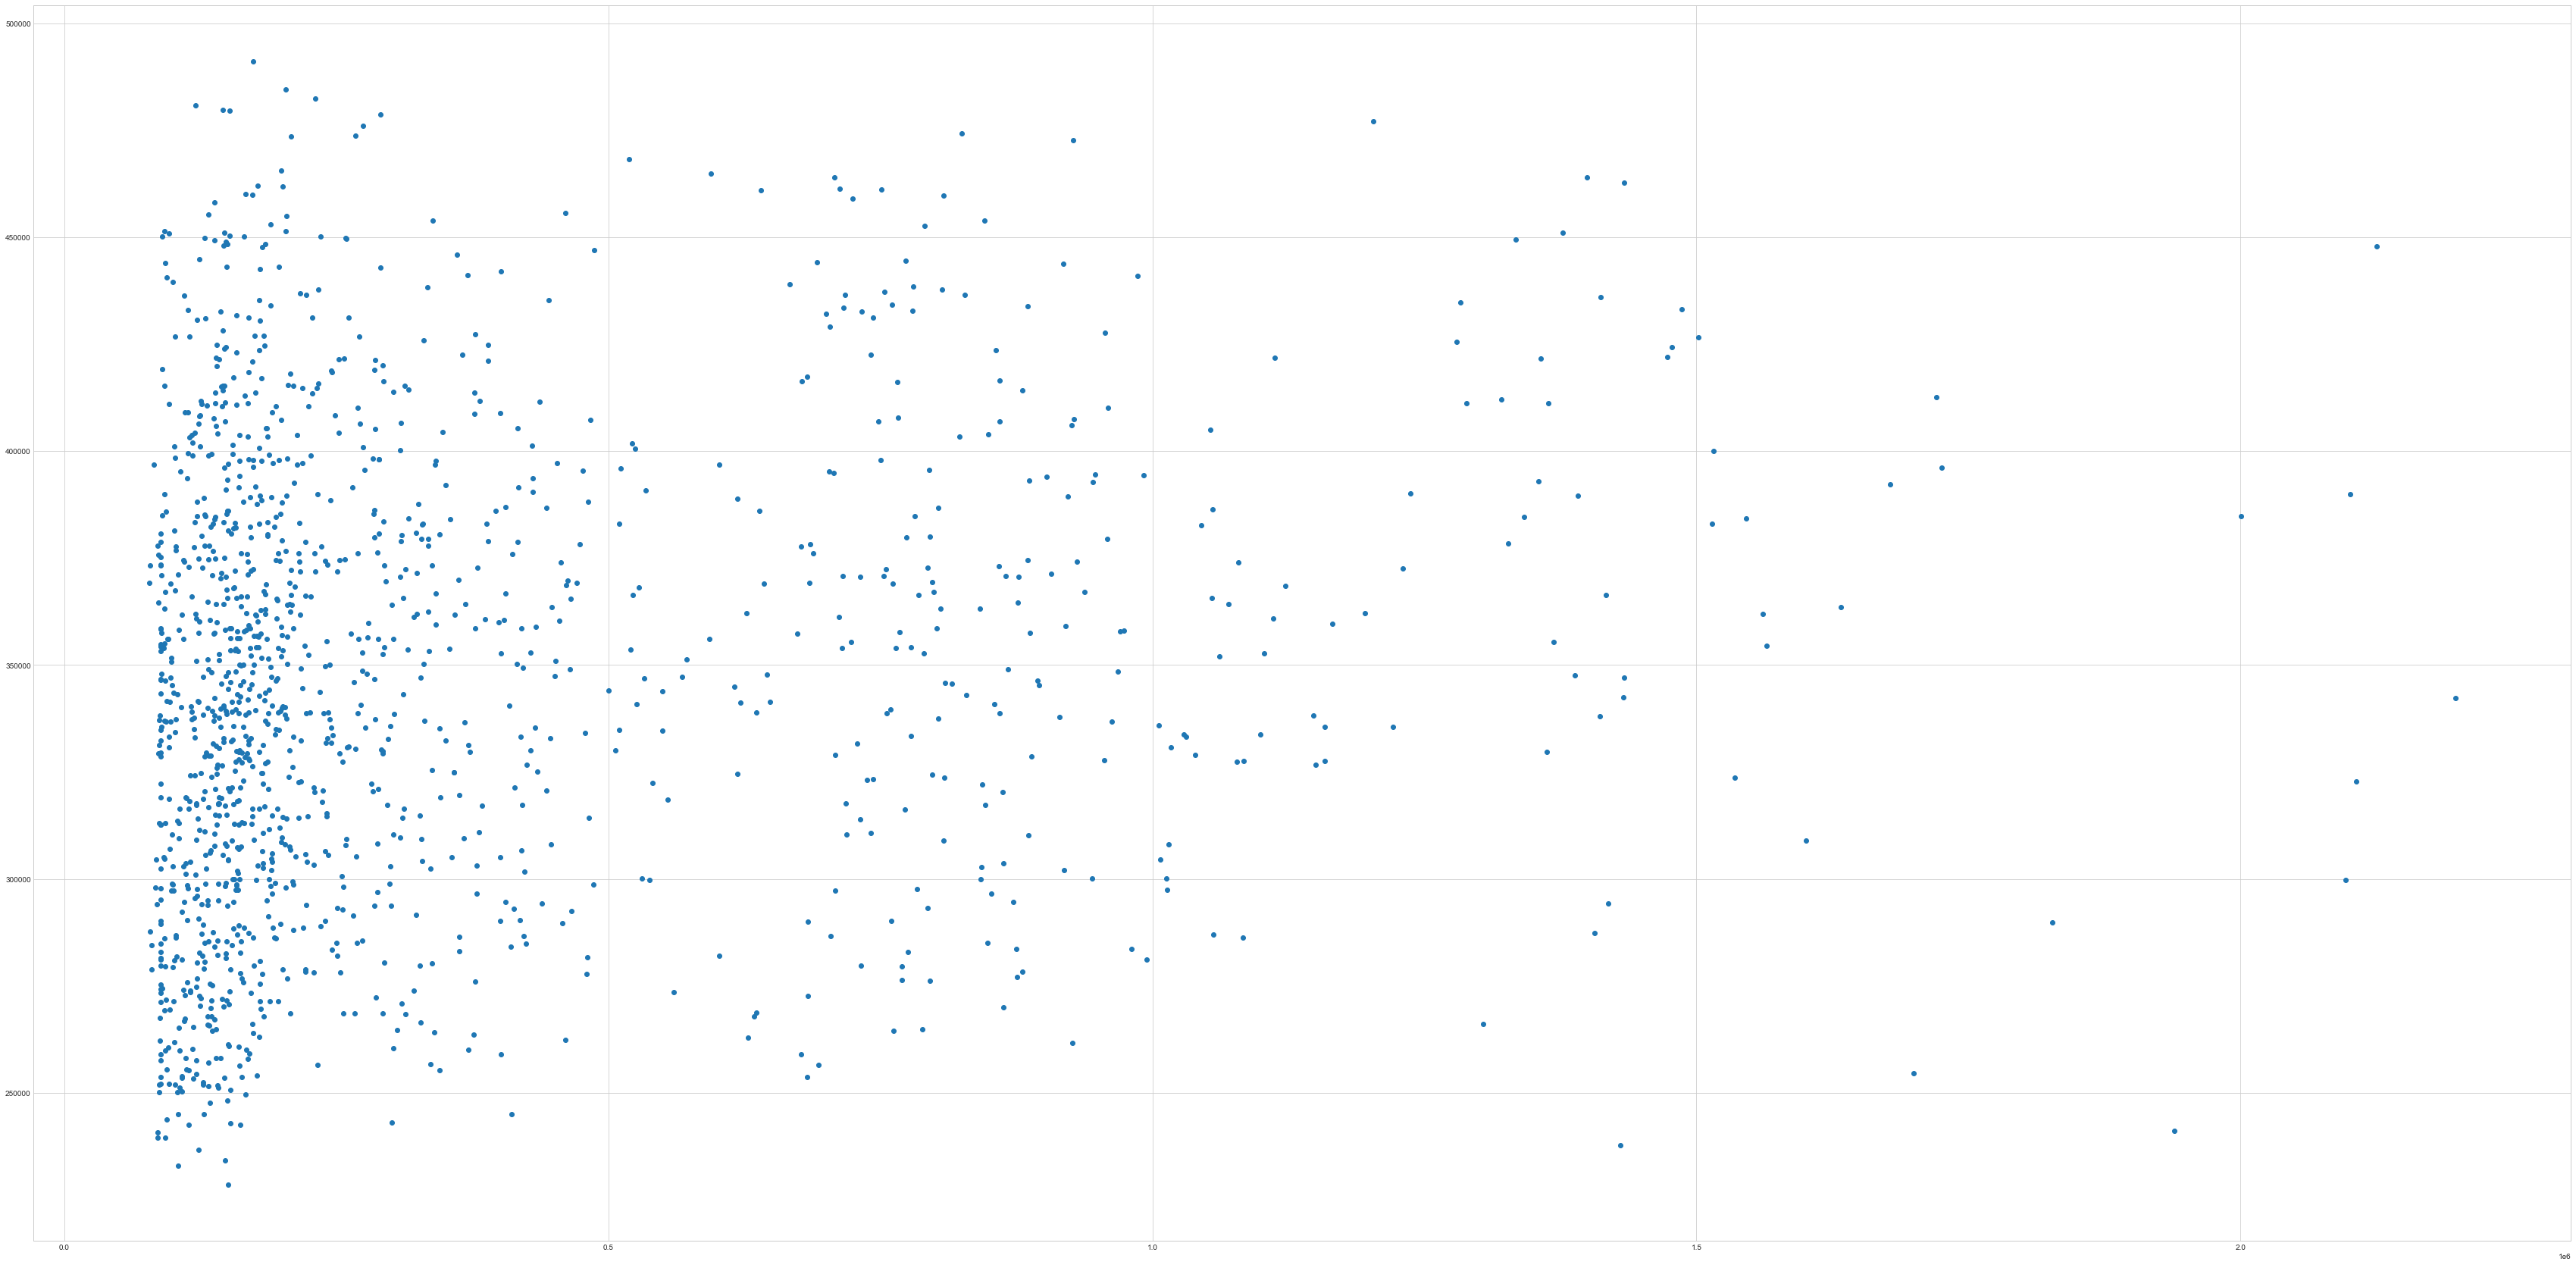

In [19]:
from sklearn.neural_network import MLPRegressor

# Numerical problems:


#parameters = [{
#'hidden_layer_sizes': [50, 100, 200], 
#'activation': ['identity', 'logistic', 'tanh', 'relu'],
#'solver': ['lbfgs', 'sgd', 'adam'],
#}]
#
#fit_and_test(GridSearchCV(MLPRegressor(max_iter=5000), parameters, scoring='r2'))


fit_and_test(MLPRegressor(max_iter=5000))